<a href="https://colab.research.google.com/github/noedelb/eccd_assignments/blob/main/Trabajo_ECCD_grupo_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**TRABAJO FINAL - Estrategias comerciales con datos**
Grupo 2:
- Florencia Britos
- Noelia Delbono
- José Kaiser
- Sofía Harley

##CARGA Y PREPROCESAMIENTO DEL DATASET

In [1]:
!pip install -q eccd_datasets pygradus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.9/223.9 kB 16.4 MB/s eta 0:00:00


In [2]:
# Download the original lables used when training a resnet

import json
!wget https://files.fast.ai/models/imagenet_class_index.json -O resnet_labels.json
with open("resnet_labels.json", "r") as fh: data = json.load(fh)
resnet_labels = {}
for k, v in data.items():
    resnet_labels[int(k)] = v[1]

--2023-12-01 22:02:50--  https://files.fast.ai/models/imagenet_class_index.json
Resolving files.fast.ai (files.fast.ai)... 172.67.69.159, 104.26.3.19, 104.26.2.19, ...
Connecting to files.fast.ai (files.fast.ai)|172.67.69.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/json]
Saving to: ‘resnet_labels.json’

resnet_labels.json  100%[===================>]  34.53K  --.-KB/s    in 0.01s   

2023-12-01 22:02:50 (3.08 MB/s) - ‘resnet_labels.json’ saved [35363/35363]



In [3]:
#Importación de librerias
import io
import torch
import pandas as pd
import torchvision.transforms as transf
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils

from torchvision import transforms
from torchvision import models
from pathlib import Path
from PIL import Image
from eccd_datasets import load_images
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from pygradus import create_exercise, check_solution

torch.manual_seed(42)

### Exploración del dataset


In [4]:
df_images = load_images()
df_images.head()

dataset coarse_cat   finegrained_cat  \
0   train      Apple  Golden-Delicious   
1   train      Apple  Golden-Delicious   
2   train      Apple  Golden-Delicious   
3   train      Apple  Golden-Delicious   
4   train      Apple  Golden-Delicious   

                                          image_data  
0  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
1  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
2  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
3  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...  
4  b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...

### Visualización de imágenes

In [5]:
def load_image_data(image_data):
    return Image.open(io.BytesIO(image_data))

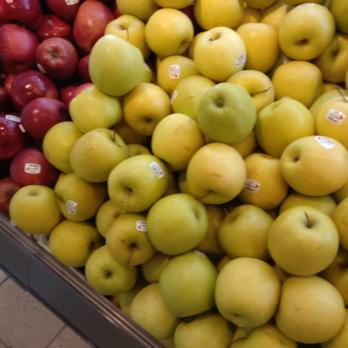

In [6]:
image = load_image_data(df_images.iloc[0]["image_data"])
image

### Imágenes como matrices

In [7]:
I = np.array(image)
print("Image shape", I.shape)
print(f"Image range in each coordinate: [{I.min()}, {I.max()}]")

Image shape (348, 348, 3)
Image range in each coordinate: [0, 255]


In [8]:
new_I = I.copy()
new_I[:, :, 0] = 0 # Killing the red channel

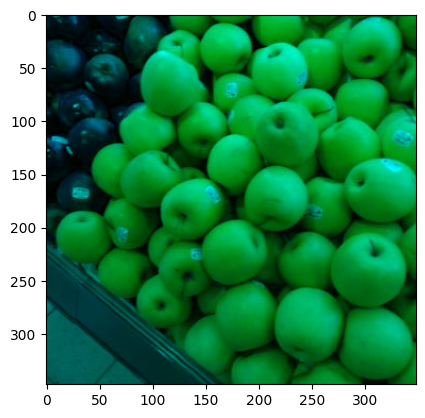

In [9]:
plt.imshow(new_I.astype(int))

### Transformaciones con PyTorch


### Resizing

In [10]:
transformation = transf.Resize((100, 100))

In [11]:
resized_image = transformation.forward(image)

Text(0.5, 1.0, 'New shape: (100, 100, 3)')

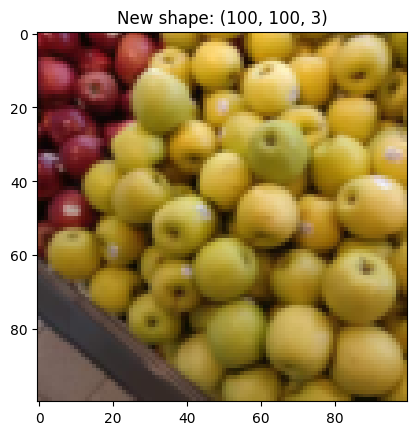

In [12]:
plt.imshow(resized_image)
plt.title(f"New shape: {np.array(resized_image).shape}")

### Center Crop

In [13]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

In [14]:
def center_crop_transformation(image, size: int) -> np.array:
    """
    This function uses a pytorch transformation to
    center and crop the image
    """
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    center_crop_transform = transf.CenterCrop(size)
    cropped_image = center_crop_transform(image)
    cropped_image_np = np.array(cropped_image)

    return cropped_image_np

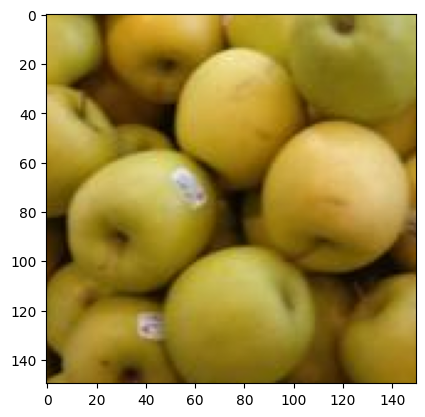

In [15]:
answer_center_crop = center_crop_transformation(image, 150)
plt.imshow(answer_center_crop)

In [16]:
assert answer_center_crop.shape == (150, 150, 3)

### RandomResizedCrop

Image original size:  (348, 348, 3)


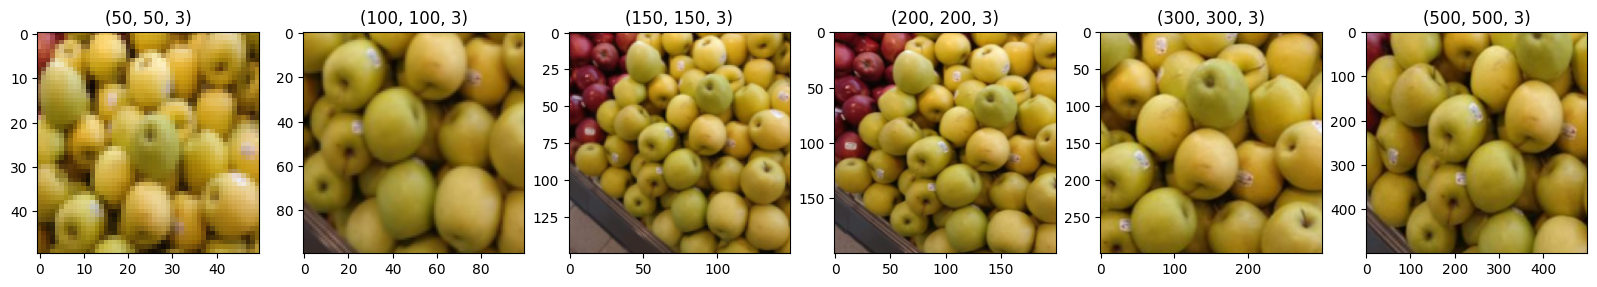

In [17]:
print("Image original size: ", np.array(image).shape)
fig, ax = plt.subplots(1, 6, figsize=(20, 4))
for i, size in enumerate([50, 100, 150, 200, 300, 500]):

    transformation = transf.RandomResizedCrop(size)

    crp_img = transformation.forward(image)
    ax[i].imshow(np.array(crp_img))
    ax[i].set_title(np.array(crp_img).shape)

## Random Horizontal Flip

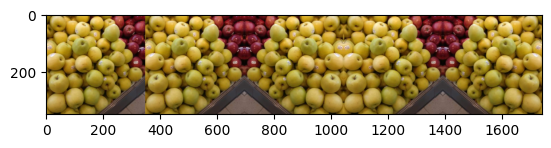

In [18]:
transformation = transf.RandomHorizontalFlip()

maybe_flipped = [transformation.forward(image) for _ in range(5)]

plt.imshow(np.hstack([np.array(img) for img in maybe_flipped]))

### Normalization

In [19]:
two_images = [load_image_data(row["image_data"]) for _, row in df_images.iloc[:2].iterrows()]

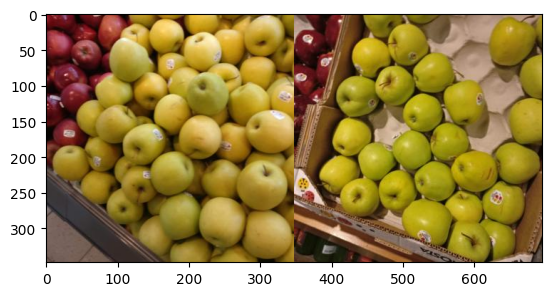

In [20]:
two_image_dataset = np.array([np.array(img) for img in two_images])
two_image_dataset.shape

plt.imshow(np.hstack([np.array(img) for img in two_images]))

In [21]:
np.mean(two_image_dataset, axis=(0, 1, 2))

array([141.43284285, 114.20849435,  44.61421588])

In [22]:
transformation = transf.Compose([
        transf.ToTensor(),
        transf.Normalize(
            np.mean(two_image_dataset, axis=(0, 1, 2)),
            np.std(two_image_dataset, axis=(0, 1, 2)),
            )
    ])

In [23]:
transformed_two_image_dataset = [transformation(img) for img in two_image_dataset]

In [24]:
transformed_two_image_dataset

[tensor([[[-2.7367, -2.7360, -2.7363,  ..., -2.7344, -2.7344, -2.7344],
          [-2.7365, -2.7366, -2.7368,  ..., -2.7344, -2.7345, -2.7346],
          [-2.7361, -2.7369, -2.7372,  ..., -2.7346, -2.7347, -2.7347],
          ...,
          [-2.7394, -2.7394, -2.7396,  ..., -2.7357, -2.7357, -2.7355],
          [-2.7394, -2.7394, -2.7395,  ..., -2.7359, -2.7357, -2.7357],
          [-2.7394, -2.7395, -2.7395,  ..., -2.7360, -2.7359, -2.7357]],
 
         [[-2.1392, -2.1384, -2.1384,  ..., -2.1298, -2.1299, -2.1299],
          [-2.1390, -2.1389, -2.1389,  ..., -2.1299, -2.1300, -2.1300],
          [-2.1386, -2.1392, -2.1392,  ..., -2.1300, -2.1301, -2.1302],
          ...,
          [-2.1339, -2.1339, -2.1342,  ..., -2.1314, -2.1314, -2.1312],
          [-2.1339, -2.1339, -2.1340,  ..., -2.1315, -2.1314, -2.1314],
          [-2.1339, -2.1340, -2.1341,  ..., -2.1317, -2.1316, -2.1314]],
 
         [[-1.0914, -1.0904, -1.0904,  ..., -1.0913, -1.0914, -1.0914],
          [-1.0911, -1.0911,

### ImageNet

In [25]:
resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 118MB/s]


In [26]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
def predict_using_resnet(image):
    """
    This image uses the resnet as is to
    predict an image.
    Remember to apply the correct transformations
    to the image before feeding it to the network.

    The following link might be useful: https://pytorch.org/hub/pytorch_vision_resnet/
    """

    resnet_transform = transf.Compose([
        transf.Resize(256),
        transf.CenterCrop(224),
        transf.ToTensor(),
        transf.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    input_tensor = resnet_transform(image)
    input_batch = input_tensor.unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_batch = input_batch.to(device)
    resnet = models.resnet18(pretrained=True)
    resnet = resnet.to(device)
    resnet.eval()

    with torch.no_grad():
        output = resnet(input_batch)

    with open("resnet_labels.json", "r") as fh:
        data = json.load(fh)
    resnet_labels = {}
    for k, v in data.items():
        resnet_labels[int(k)] = v[1]

    _, predicted_idx = torch.max(output, 1)
    predicted_label = resnet_labels[predicted_idx.item()]

    return predicted_label

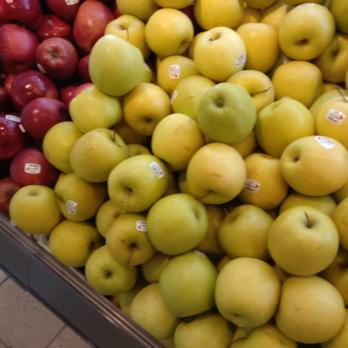

In [28]:
img1 = (
    load_image_data(
        df_images[
            df_images["coarse_cat"] == "Apple"
        ]
        .iloc[0]
        ["image_data"]
    )

)
img1

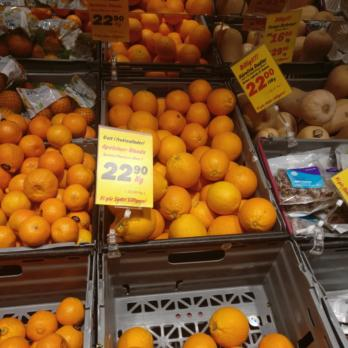

In [29]:
img2 = (
    load_image_data(
        df_images[
            df_images["coarse_cat"] == "Orange"
        ]
        .iloc[0]
        ["image_data"]
    )

)
img2

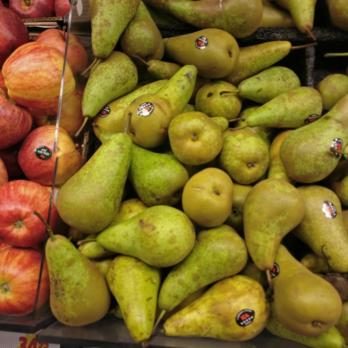

In [30]:
img3 = (
    load_image_data(
        df_images[
            df_images["coarse_cat"] == "Pear"
        ]
        .iloc[0]
        ["image_data"]
    )

)
img3

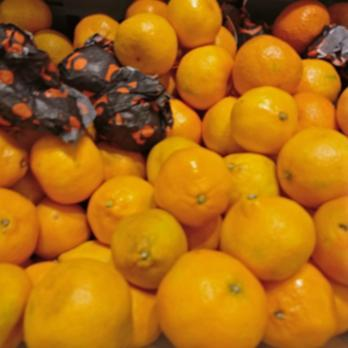

In [31]:
img4 = (
    load_image_data(
        df_images[
            df_images["coarse_cat"] == "Satsumas"
        ]
        .iloc[0]
        ["image_data"]
    )

)
img4

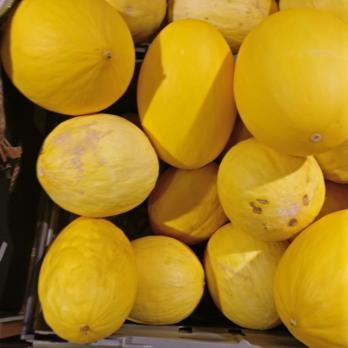

In [32]:
img5 = (
    load_image_data(
        df_images[
            df_images["coarse_cat"] == "Melon"
        ]
        .iloc[0]
        ["image_data"]
    )

)
img5

## ENTRENAMIENTO DEL MODELO

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


train Epoch 0/15 Loss: 0.8315 Acc: 0.6860
test Epoch 0/15 Loss: 0.4321 Acc: 0.8257
train Epoch 1/15 Loss: 0.6420 Acc: 0.7726
test Epoch 1/15 Loss: 0.1185 Acc: 0.9576
train Epoch 2/15 Loss: 0.4806 Acc: 0.8345
test Epoch 2/15 Loss: 0.0896 Acc: 0.9664
train Epoch 3/15 Loss: 0.4188 Acc: 0.8500
test Epoch 3/15 Loss: 0.0800 Acc: 0.9708
train Epoch 4/15 Loss: 0.4692 Acc: 0.8423
test Epoch 4/15 Loss: 0.1388 Acc: 0.9474
train Epoch 5/15 Loss: 0.3574 Acc: 0.8729
test Epoch 5/15 Loss: 0.0339 Acc: 0.9898
train Epoch 6/15 Loss: 0.2616 Acc: 0.9051
test Epoch 6/15 Loss: 0.0359 Acc: 0.9888
train Epoch 7/15 Loss: 0.3267 Acc: 0.8905
test Epoch 7/15 Loss: 0.0960 Acc: 0.9708
train Epoch 8/15 Loss: 0.3099 Acc: 0.9065
test Epoch 8/15 Loss: 0.0763 Acc: 0.9800
train Epoch 9/15 Loss: 0.2845 Acc: 0.9133
test Epoch 9/15 Loss: 0.0290 Acc: 0.9917
train Epoch 10/15 Loss: 0.2599 Acc: 0.9216
test Epoch 10/15 Loss: 0.1423 Acc: 0.9547
train Epoch 11/15 Loss: 0.1940 Acc: 0.9284
test Epoch 11/15 Loss: 0.0200 Acc: 0.9942


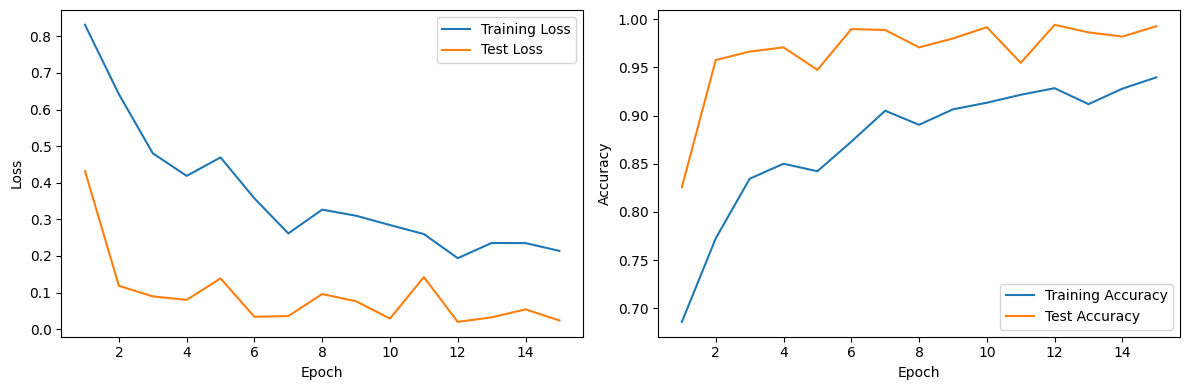

In [33]:
# Desarrollo y entrenamiento del modelo

# Crear el dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.classes = list(set(dataframe['coarse_cat']))

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_data = self.dataframe.iloc[idx, 3]  # Obtén la columna "image_data"
        image = Image.open(io.BytesIO(img_data)).convert("RGB")  # Convierte datos binarios a imagen

        label = self.dataframe.iloc[idx, 1]  # Obtén la columna "finegrained_cat"

        if self.transform:
            image = self.transform(image)

        return image, label

# Definir las transformaciones
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Crear instancias para el conjuntos de entrenamiento, validación y test
image_datasets = {x: CustomDataset(dataframe=df_images, transform=data_transforms[x]) for x in ['train', 'val', 'test']}

# Crear DataLoaders para el conjuntos de entrenamiento, validación y test
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# Definir el tamaño del conjunto de datos
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

# Nombrar las clases
class_names = list(set(df_images['coarse_cat']))

# Verificar si hay GPU disponible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Definir el modelo
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

# Mover el modelo a la GPU si está disponible
model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Inicializar listas para almacenar los resultados
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Definir número de épocas
num_epochs = 15

# Ciclo de entrenamiento
for epoch in range(num_epochs):
    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        corrects = 0

        label_to_index = {label: idx for idx, label in enumerate(class_names)}

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)

            # Verificar si labels es un tensor
            if torch.is_tensor(labels):
                labels = labels.to(device)
            elif isinstance(labels, tuple):
                labels = tuple(torch.tensor(label_to_index[label]).to(device).unsqueeze(0) for label in labels)
                labels = torch.cat(labels, dim=0)
            else:
                labels = torch.tensor(label_to_index[labels]).to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

        # Calcular la pérdida y precisión al final de la época
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = corrects.double() / dataset_sizes[phase]

        # Actualizar las listas de pérdidas y precisión
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc.item())
        else:
            test_losses.append(epoch_loss)
            test_accuracies.append(epoch_acc.item())

        print(f'{phase} Epoch {epoch}/{num_epochs} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

# Graficar pérdida y precisión
plt.figure(figsize=(12, 4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [34]:
# Calcular accuracy por ítem

# Predicciones en el conjunto de prueba
model.eval()
all_predictions = []
all_true_labels = []  # Añadir esta línea para almacenar las etiquetas verdaderas

# Crear un mapeo de etiquetas a índices
label_to_index = {label: idx for idx, label in enumerate(image_datasets['test'].classes)}

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)

        # Caso en el que las etiquetas son una tupla o una cadena
        if isinstance(labels, tuple):
            labels = tuple(torch.tensor(label_to_index[label]).to(device) for label in labels)
        else:
            labels = torch.tensor(label_to_index[labels]).to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_predictions.extend(preds.cpu().numpy())

        # Corregir para almacenar las etiquetas verdaderas
        if isinstance(labels, tuple):
            all_true_labels.extend([torch.tensor(label).cpu().numpy() for label in labels])
        else:
            all_true_labels.extend([labels.cpu().numpy()])

# Convertir las listas a matrices
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Obtener las etiquetas predichas en el conjunto de validación
model.eval()
val_loader = DataLoader(image_datasets['val'], batch_size=len(image_datasets['val']), shuffle=True, num_workers=4)
val_inputs, val_labels = next(iter(val_loader))
val_inputs = val_inputs.to(device)

# Hacer las predicciones
with torch.no_grad():
    val_outputs = model(val_inputs)

# Obtener las etiquetas predichas
_, val_preds = torch.max(val_outputs, 1)
val_predicted_labels = [image_datasets['val'].classes[pred.item()] for pred in val_preds]

# Calcular la precisión por categoría de fruta
precisiones_por_fruta = {}

frutas_unicas = set(image_datasets['test'].classes)

# Precios reales y predichos
fruit_prices_reales = {'Apple': 74, 'Pear': 89, 'Satsumas': 44, 'Melon': 109, 'Orange': 35}
fruit_prices_pred = {'Apple': 74, 'Pear': 89, 'Satsumas': 44, 'Melon': 109, 'Orange': 35}

for fruta in frutas_unicas:
    # Obtener índices correspondientes a la fruta
    indices_fruta = [idx for idx in range(len(all_true_labels)) if image_datasets['test'][idx][1] == fruta]

    # Extraer etiquetas verdaderas y predicciones
    etiquetas_verdaderas_fruta = all_true_labels[indices_fruta]
    predicciones_fruta = all_predictions[indices_fruta]

    # Calcular la precisión
    precision_fruta = accuracy_score(etiquetas_verdaderas_fruta, predicciones_fruta)

    precisiones_por_fruta[fruta] = precision_fruta

# Imprimir precisiones por fruta
for fruta, precision in precisiones_por_fruta.items():
    print(f'Precisión para {fruta}: {precision:.4f}')


<ipython-input-34-9ccda540ca0b>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_true_labels.extend([torch.tensor(label).cpu().numpy() for label in labels])


Precisión para Pear: 1.0000
Precisión para Orange: 0.9885
Precisión para Satsumas: 0.9858
Precisión para Melon: 0.9938
Precisión para Apple: 0.9918


In [35]:
# Calcular el costo en el set de test
costo = [5 * (fruit_prices_pred[pred] - fruit_prices_reales[label]) if fruit_prices_pred[pred] > fruit_prices_reales[label] else fruit_prices_reales[label] - fruit_prices_pred[pred] for pred, label in zip(val_predicted_labels, val_labels)]
suma_total_costo = sum(costo)

print(f'Suma total del costo en el conjunto de test: {suma_total_costo}')

Suma total del costo en el conjunto de test: 648


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


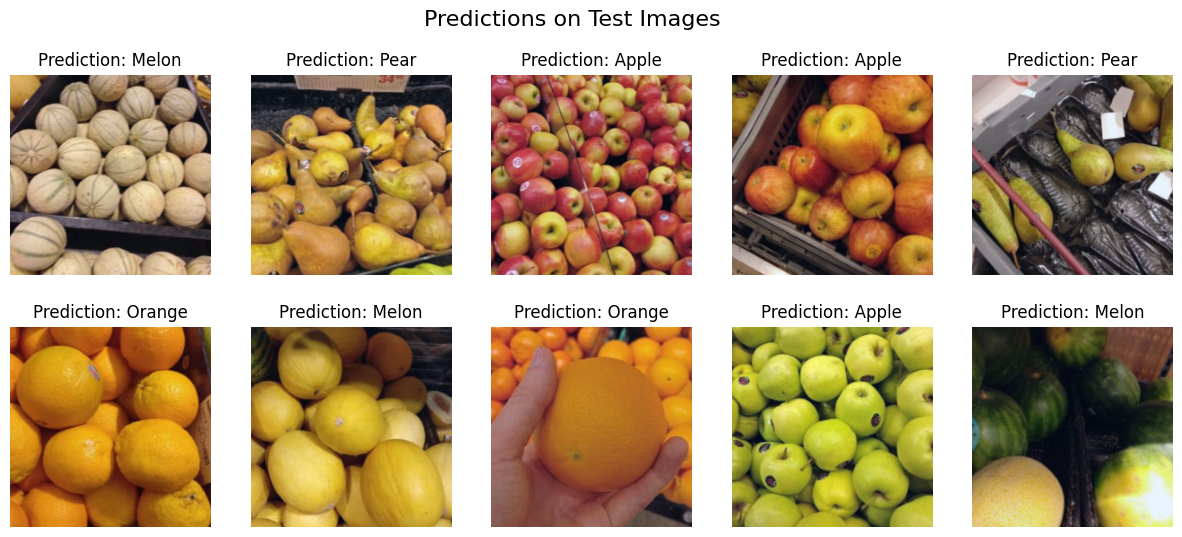

In [36]:
# Visualizar algunos resultados del modelo

model.eval()

# Elige 10 imágenes
sample_loader = DataLoader(image_datasets['test'], batch_size=10, shuffle=True, num_workers=4)
inputs, labels = next(iter(sample_loader))
inputs = inputs.to(device)

# Hacer las predicciones
with torch.no_grad():
    outputs = model(inputs)

# Obtener las etiquetas predichas
_, preds = torch.max(outputs, 1)
predicted_labels = [class_names[pred.item()] for pred in preds]

# Mostrar cada imagen con su predicción
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Predictions on Test Images', fontsize=16)

for i in range(10):
    img = vutils.make_grid(inputs[i].unsqueeze(0).cpu(), normalize=True)
    axs[i // 5, i % 5].imshow(img.permute(1, 2, 0).numpy())
    axs[i // 5, i % 5].set_title(f'Prediction: {predicted_labels[i]}')
    axs[i // 5, i % 5].axis('off')

plt.show()

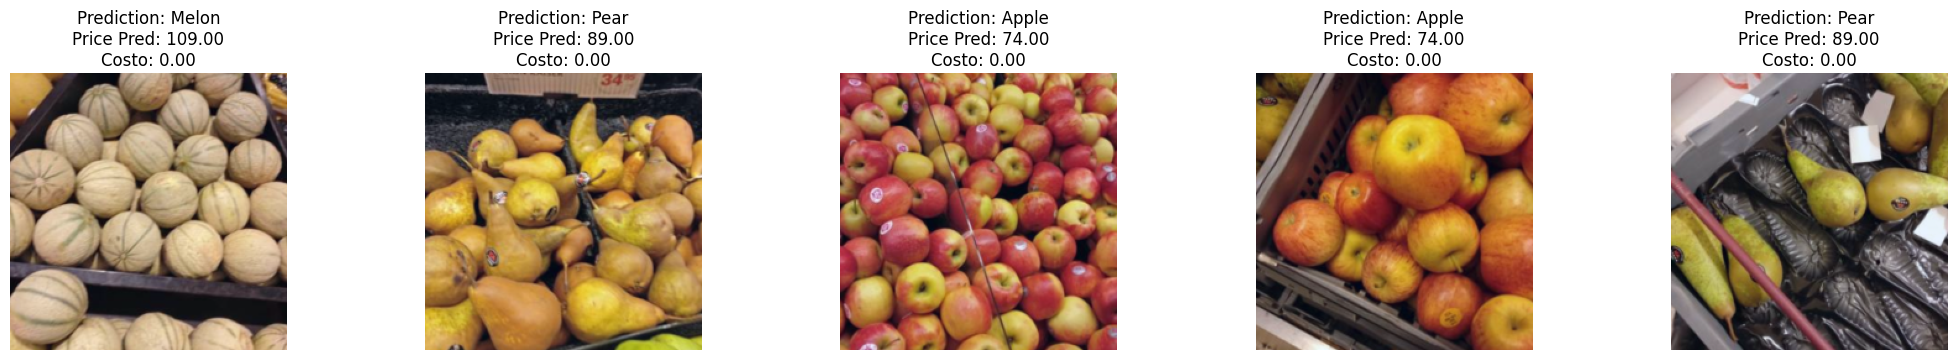

In [37]:
# Visualizar el costo asociado según la predicción obtenida

# Lista de precios
fruit_prices = {'Apple': 74, 'Pear': 89, 'Satsumas': 44, 'Melon': 109, 'Orange': 35}

# Hacer las predicciones
with torch.no_grad():
    outputs = model(inputs)

# Obtener las etiquetas predichas
_, preds = torch.max(outputs, 1)
predicted_labels = [class_names[pred.item()] for pred in preds]

# Calcular precios predichos y reales
prices_pred = [fruit_prices[label] for label in predicted_labels]
prices_real = [fruit_prices[label] for label in labels]

# Calcular el costo según las condiciones definidas por el cliente
costo = [5 * (price_pred - price_real) if price_pred > price_real else price_real - price_pred for price_pred, price_real in zip(prices_pred, prices_real)]

# Mostrar cada imagen con su predicción, precio predicho y costo
fig, axs = plt.subplots(1, min(5, len(inputs)), figsize=(25, 4))

for i in range(min(5, len(inputs))):
    img = vutils.make_grid(inputs[i].unsqueeze(0).cpu(), normalize=True)
    axs[i].imshow(img.permute(1, 2, 0).numpy())
    axs[i].set_title(f'Prediction: {predicted_labels[i]}\nPrice Pred: {prices_pred[i]:.2f}\nCosto: {costo[i]:.2f}')
    axs[i].axis('off')

plt.subplots_adjust(wspace=0.5)
plt.show()
